# Preparing

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from load_data import load_mnist
from util import *
from acq_functions import *
import os

np.random.seed(43)

x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_mnist()

x_train shape: torch.Size([60000, 1, 28, 28])
60000 train samples, before reduction
10000 test samples
(tensor([    1,    21,    34,  ..., 59952, 59972, 59987]),)
(tensor([    3,     6,     8,  ..., 59979, 59984, 59994]),)
(tensor([    5,    16,    25,  ..., 59983, 59985, 59991]),)
(tensor([    7,    10,    12,  ..., 59978, 59980, 59996]),)
(tensor([    2,     9,    20,  ..., 59943, 59951, 59975]),)
(tensor([    0,    11,    35,  ..., 59968, 59993, 59997]),)
(tensor([   13,    18,    32,  ..., 59982, 59986, 59998]),)
(tensor([   15,    29,    38,  ..., 59963, 59977, 59988]),)
(tensor([   17,    31,    41,  ..., 59989, 59995, 59999]),)
(tensor([    4,    19,    22,  ..., 59973, 59990, 59992]),)


In [2]:
batch_size = 128
epochs = 70
acquired_points = 10
acquisition_times = 100
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new = x_train_new.to(device)
y_train_new = y_train_new.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # /2 width/height
        )

        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 11 * 11, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [ ]:
acq_funs = {
    "random": random,
    "bald": bald
}


In [5]:
sampling_steps = 5
mc_sampling = False

# Train part local


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import gc

def find_best_decay_local(x_train, y_train):

    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):

        model = CNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        criterion = rmse_loss
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb.to(dtype=torch.float32))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            
            total_loss = 0

        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model)

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = CNN().to(device)
    best_model.load_state_dict(best_model_state)

    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, best_model)
    return best_model, test_acc

In [7]:
def train_once_local_opt(
        x_train_cur, y_train_cur,
        acquisition_fn,
        Xs):

    model_curr, test_score = find_best_decay_local(
        x_train_cur, y_train_cur
    )

    acq_lambda = lambda x: acquisition_fn(100, model_curr, x)
    acq_scores = call_batchwise(acq_lambda, Xs, batch_size=32, device=device)

    del model_curr # save space if running locally
    gc.collect()
    if device == "mps":
        torch.mps.empty_cache()
    elif device == "cuda":
        torch.cuda.empty_cache()
    _, topk_idx = torch.topk(acq_scores, acquired_points)
    return test_score, topk_idx

In [8]:
from tqdm import tqdm

def train_full_local(acquisition_fn, Xs, ys, x_init_train, y_init_train):

    scores = []

    # Copies of initial training set as they are changed
    x_train_cur = x_init_train.clone()
    y_train_cur = y_init_train.clone()

    for _ in tqdm(range(acquisition_times)):
        score, x_new = train_once_local_opt(x_train_cur, y_train_cur, acquisition_fn, Xs)
        x_new_t = torch.tensor(x_new, dtype=torch.long)
        x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
        y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
        mask = torch.ones(Xs.shape[0], dtype=torch.bool)
        mask[x_new_t.cpu()] = False
        Xs = Xs[mask]
        ys = ys[mask]

        scores.append(score)

    model, final_score = find_best_decay_local(x_train_cur, y_train_cur)
    scores.append(final_score)
    scores = torch.tensor(scores, dtype=torch.float32)

    return scores, model


In [9]:
def train_acquisition_local(acq_fun):
    scores = []
    os.makedirs("./results", exist_ok=True)

    for i in range(3):
        if os.path.exists(f"./results/{i}{str(acq_fun)}_rmse.npy"):
            score = np.load(f"./results/{i}{str(acq_fun)}_rmse.npy")
            score = torch.Tensor(score).to(device=device)
        else:
            score, model = train_full_local(acq_funs[acq_fun], X_p, y_p, x_train_new, y_train_new)
            print(score)
            np.save(f"./results/{i}{str(acq_fun)}_rmse.npy", score.cpu().numpy())
        scores.append(score)

    meaned_scores = torch.stack(scores, dim=0).mean(dim=0)
    return meaned_scores


In [12]:
results_local = {}
for acq_fun in acq_funs:
  res = train_acquisition_local(acq_fun)
  print(res)
  np.save(f"./results/{str(acq_fun)}_rmse.npy", res.cpu().numpy())
  results_local[acq_fun] = res

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9_/b7fsj07x3p78x_60wdfj2z_h0000gn/T/ipykernel_75615/3584722138.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_t = torch.tensor(x_new, dtype=torch.long)
100%|██████████| 100/100 [53:54<00:00, 32.35s/it]


tensor([0.2530, 0.2561, 0.2367, 0.2247, 0.2145, 0.2140, 0.2041, 0.2003, 0.2001,
        0.1971, 0.1925, 0.2188, 0.1854, 0.1832, 0.1814, 0.1744, 0.1707, 0.1747,
        0.1668, 0.1645, 0.1653, 0.1656, 0.1586, 0.1541, 0.1718, 0.1646, 0.1587,
        0.1602, 0.1534, 0.1516, 0.1494, 0.1557, 0.1538, 0.1532, 0.1425, 0.1457,
        0.1443, 0.1461, 0.1402, 0.1468, 0.1418, 0.1396, 0.1392, 0.1392, 0.1362,
        0.1341, 0.1339, 0.1339, 0.1395, 0.1322, 0.1398, 0.1327, 0.1344, 0.1304,
        0.1312, 0.1328, 0.1360, 0.1314, 0.1254, 0.1218, 0.1263, 0.1259, 0.1228,
        0.1333, 0.1402, 0.1256, 0.1203, 0.1313, 0.1312, 0.1317, 0.1205, 0.1222,
        0.1183, 0.1190, 0.1249, 0.1332, 0.1239, 0.1162, 0.1256, 0.1198, 0.1192,
        0.1234, 0.1191, 0.1215, 0.1177, 0.1200, 0.1228, 0.1216, 0.1201, 0.1135,
        0.1207, 0.1189, 0.1160, 0.1188, 0.1198, 0.1184, 0.1119, 0.1170, 0.1157,
        0.1159, 0.1161])


100%|██████████| 100/100 [54:19<00:00, 32.59s/it]


tensor([0.2511, 0.2425, 0.2366, 0.2388, 0.2304, 0.2248, 0.2212, 0.2118, 0.2081,
        0.1995, 0.1978, 0.2074, 0.1913, 0.1953, 0.1822, 0.1766, 0.1715, 0.1683,
        0.1774, 0.1676, 0.1640, 0.1635, 0.1690, 0.1640, 0.1736, 0.1642, 0.1705,
        0.1547, 0.1540, 0.1536, 0.1489, 0.1572, 0.1545, 0.1551, 0.1447, 0.1411,
        0.1405, 0.1566, 0.1422, 0.1414, 0.1470, 0.1334, 0.1459, 0.1365, 0.1346,
        0.1308, 0.1392, 0.1322, 0.1360, 0.1387, 0.1351, 0.1333, 0.1407, 0.1294,
        0.1327, 0.1272, 0.1305, 0.1339, 0.1311, 0.1331, 0.1272, 0.1361, 0.1266,
        0.1380, 0.1266, 0.1308, 0.1240, 0.1301, 0.1206, 0.1225, 0.1262, 0.1267,
        0.1211, 0.1221, 0.1276, 0.1500, 0.1328, 0.1270, 0.1358, 0.1261, 0.1194,
        0.1225, 0.1186, 0.1210, 0.1198, 0.1327, 0.1201, 0.1144, 0.1224, 0.1257,
        0.1178, 0.1255, 0.1195, 0.1148, 0.1182, 0.1136, 0.1215, 0.1147, 0.1180,
        0.1237, 0.1087])


100%|██████████| 100/100 [50:51<00:00, 30.51s/it]


tensor([0.2534, 0.2510, 0.2238, 0.2182, 0.2170, 0.2087, 0.2133, 0.2084, 0.2024,
        0.1992, 0.1927, 0.2173, 0.1910, 0.1878, 0.1750, 0.1876, 0.1775, 0.1735,
        0.1679, 0.1692, 0.1637, 0.1587, 0.1622, 0.1566, 0.1737, 0.1607, 0.1560,
        0.1609, 0.1561, 0.1568, 0.1467, 0.1462, 0.1471, 0.1474, 0.1476, 0.1447,
        0.1538, 0.1543, 0.1508, 0.1397, 0.1366, 0.1450, 0.1350, 0.1383, 0.1333,
        0.1351, 0.1308, 0.1375, 0.1292, 0.1337, 0.1382, 0.1331, 0.1327, 0.1310,
        0.1356, 0.1285, 0.1308, 0.1348, 0.1320, 0.1315, 0.1368, 0.1347, 0.1267,
        0.1251, 0.1311, 0.1373, 0.1282, 0.1327, 0.1240, 0.1250, 0.1239, 0.1232,
        0.1281, 0.1234, 0.1233, 0.1388, 0.1287, 0.1302, 0.1195, 0.1256, 0.1230,
        0.1251, 0.1304, 0.1206, 0.1219, 0.1191, 0.1202, 0.1242, 0.1311, 0.1210,
        0.1181, 0.1125, 0.1172, 0.1148, 0.1206, 0.1119, 0.1175, 0.1138, 0.1098,
        0.1185, 0.1157])
tensor([0.2525, 0.2499, 0.2324, 0.2272, 0.2207, 0.2158, 0.2129, 0.2068, 0.2036,
        0.1986,

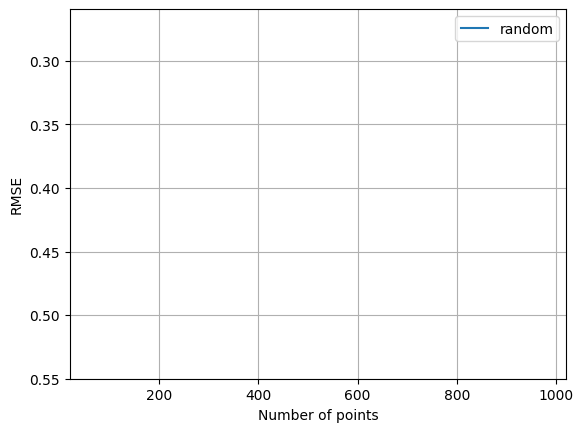

In [13]:
import matplotlib.ticker as mt
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local:
  plt.plot(steps, results_local[key].cpu().numpy(), label=key)
ax = plt.gca()
ax.yaxis.set_major_locator(mt.MultipleLocator(0.05))
plt.grid()
plt.ylim(bottom=0.55)
plt.xlim(left=20, right=1020)
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./local_acq_plot.svg")